Based off of work done by Frost Et al in PlosBiology, 2021: https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001235

## Goal:
Develop a set of neural networks that are able to evaluate the information content contained within the correlation structure of matrices containing neural time-series

In [2]:
### Import all the necessary libraries
#!pip install --upgrade numpy #need numppy 1.7 to use code
import scipy.io
import numpy as np
import matplotlib
import random 

from matplotlib import pyplot as plt

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image
from torchvision.transforms import ToTensor

from google.colab import drive
drive.mount('/content/drive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
print(np.__version__)

Mounted at /content/drive
Using cpu device
1.21.5


In [3]:
def make_rand_labels(label_len):
  rand_vec = np.random.rand(1, label_len) >= 0.5
  return rand_vec.astype(int)


### Import real sample data saved in google drive


In [4]:
mat_filename = '/content/drive/MyDrive/' + 'Dx_7-1_RS1_VEH_Spikes_thresh.mat'
mat = scipy.io.loadmat(mat_filename);
spikes = torch.from_numpy(mat['spikes']) #convert numpy array of raster to tensor 

#import real (sample) label vector 
real_label_filename = '/content/drive/MyDrive/' + 'Dlx_C7-1_RS1_VEH_paddedLabels.mat'
label_mat = scipy.io.loadmat(real_label_filename);
label_vector= label_mat[list(label_mat.keys())[3]][0]

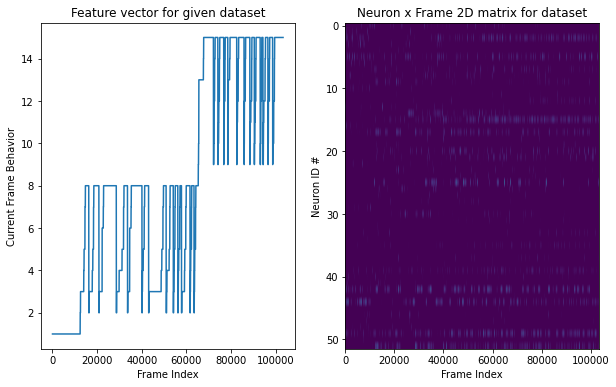

In [5]:
fig, ax = plt.subplots(1,2, figsize = (10,6))

ax[0].plot(label_vector);
ax[0].set_title("Feature vector for given dataset");
ax[0].set_xlabel('Frame Index');
ax[0].set_ylabel('Current Frame Behavior');

ax[1].imshow(spikes, aspect = 'auto');
ax[1].set_title("Neuron x Frame 2D matrix for dataset");
ax[1].set_xlabel('Frame Index');
ax[1].set_ylabel('Neuron ID #');

In [45]:
#make prediction and losses dict for later 
predictions_dict = dict()
losses_dict = dict()
report_info = dict()


new random vector shape is (1, 103362)


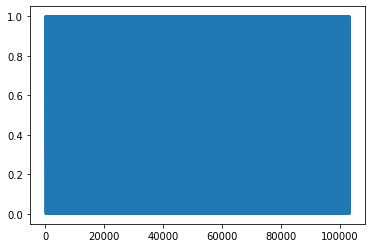

In [50]:
# make deterministic raster for testing network
random_label_vec = make_rand_labels(label_vector.shape[0])

label_mask = random_label_vec == 1
label_mask = label_mask #create numpy boolean mask for indexing

print('new random vector shape is' , random_label_vec.shape)
plt.plot(random_label_vec.ravel());

### Testing pytorch network on simulated dataset
To verify the network architecture is able to learn, a sample dataset is created, of equal size as the real calcium dataset (Neuron x Observation matrix) . This dataset has activity (defined as Element in row n, column o/E_n,o = 1)in a subset of simulated units. The network is then trained on said simulated dataset.

new raster shape is(50, 103362)


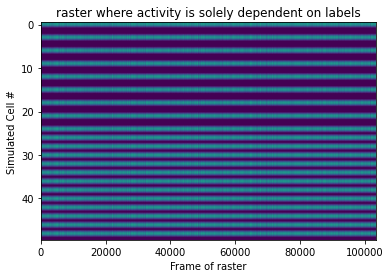

In [53]:

d_raster_size = 50
#create raster that is dependent on random labels
dependent_raster = np.zeros((d_raster_size,label_mask.shape[1]))
dependent_raster[0:round(d_raster_size/2):3, label_mask.ravel()] = 1
dependent_raster[round(d_raster_size/2)+1::2, label_mask.ravel()] = 1

print('new raster shape is' + str(dependent_raster.shape))

plt.imshow(dependent_raster, aspect = 'auto');
plt.title('raster where activity is solely dependent on labels');
plt.xlabel('Frame of raster');
plt.ylabel('Simulated Cell #');

In [58]:
## NETWORK CLASS STORAGE

#build neural network based off frost et al., with 1000 hidden layer units outputting to a single sigmoid output unit
#Most importantly, this network will use mean squared error as the loss funciton 
class frost_net(nn.Module):
    def __init__(self): #input in the number of neurons you want to use 
        super(frost_net, self).__init__()

        #self.encoder = nn.Sequential(nn.Linear(num_neurons,1000),nn.ReLU(),nn.Linear(1000,1),)
        self.fc1 = nn.Linear(1000, 1) #1000 neurons in, 1 OUT
        self.sigmoid = nn.Sigmoid()
        #create output layer

    def forward(self, x):
        #need to transpose X, as linear layers require (, Xin) shaped tensors
        x = self.fc1(x.float()) #pass 1st layer input (numNeurons ->1000),
        #REMOVING RELU because frost et al. just feed data directly from input to hidden layer
        #x = self.relu(x)#then apply relu
        x = self.sigmoid(x) #then apply sigmoid for output
        return x


In [ ]:
#replicate frost et al., architecture


# randomly set up weights from the input neurons to the hidden layer units


In [62]:
#test that architecture is set up correctly
frost_test = frost_net()
random_data = torch.rand((1,1000)) #size is transposed version of architefcture
result = frost_test(random_data)
print(result, frost_test)


tensor([[0.4285]], grad_fn=<SigmoidBackward0>) frost_net(
  (fc1): Linear(in_features=1000, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
